# Using the analog frontend model

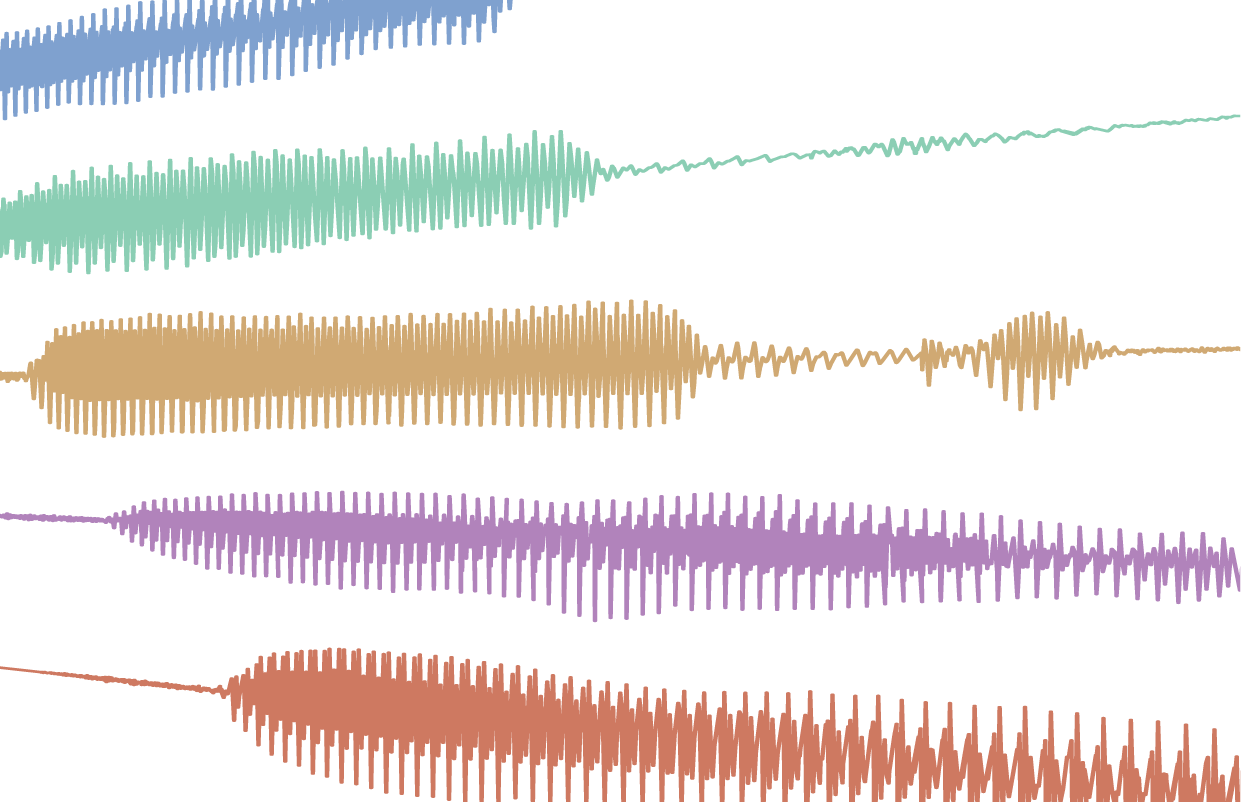

In [1]:
# - Image display
from IPython.display import Image
Image("images/vowels-audio-splash.png")

In [2]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Import numpy
import numpy as np
import scipy as sp

# - Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 300

# - Rich printing
try:
    from rich import print
except:
    pass

## The audio front-end module

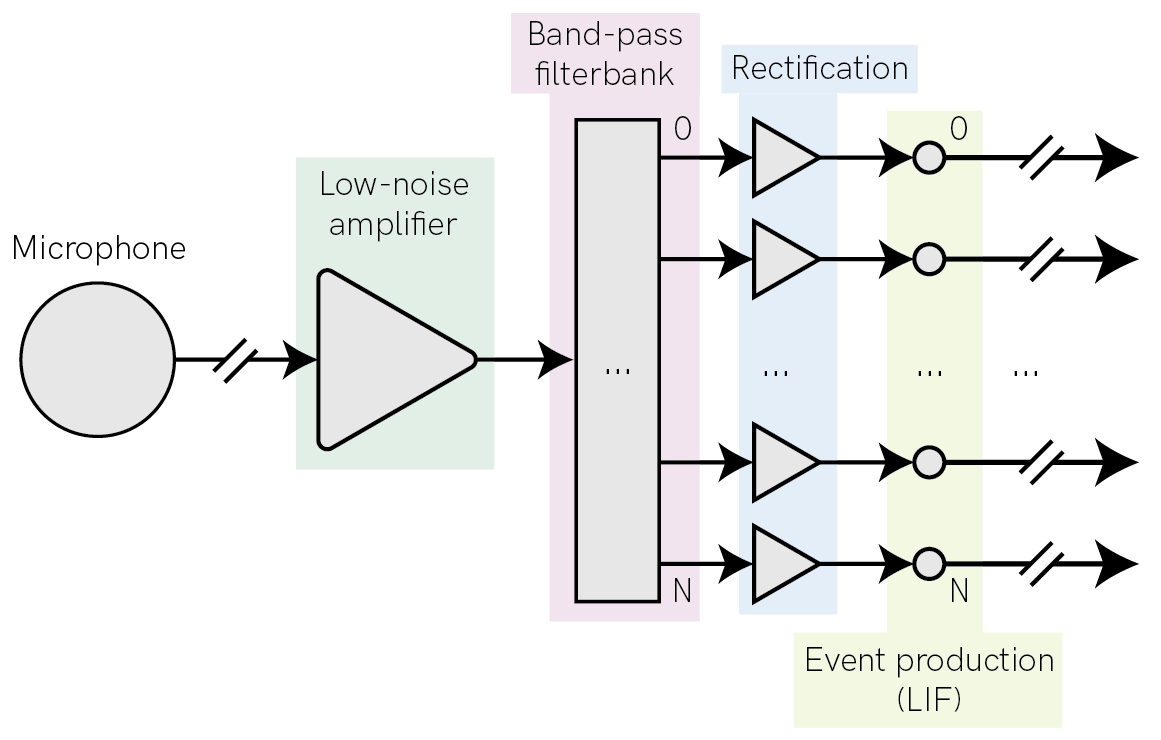

In [3]:
Image("images/audio-front-end.png")

## Parameter definition and initialization

In [4]:
# - import AFE
from rockpool.devices.pollen import AFE

/Users/Shared/anaconda3/envs/py36_tf/lib/python3.6/site-packages/samna
finished bindings


In [5]:
# - AFE parameters

num_filters = 16         # number of filters (on the AFE hardware, this is fixed to 16)
Q = 5                    # Q (Quality) factor for the filters
fc1 = 100.               # center frequency of the first filter in Hz
f_factor = 1.325         # scaling to determine the center frequencies of the subsequent filters

fs = 48000               # sampling frequency for the input data, in Hz
LNA_gain = 0.0           # gain of the Low-Noise amplifier in dB

thr_up = 0.8             # threshold of the neurons used for signal-to-event conversion
leakage = 5.0            # leakage of the neurons used for event conversion
digital_counter = 8      # digital counter for event conversion. This is a factor to decrease the event rate by

manual_scaling = None    # if `None`, input is normalised automatically prior to the LNA
add_noise = True         # add simulated noise on each stage of the filtering
seed = None              # the AFE is subject to random mismatch, the mismatch can be seeded

# - Initialize the AFE simulation, and convert it to a high-level `TimedModule`

afe = AFE(Q=Q,
          fc1=fc1,
          f_factor=f_factor,
          thr_up=thr_up,
          leakage=leakage,
          LNA_gain=LNA_gain,
          fs=fs,
          digital_counter=digital_counter,
          shape=num_filters,
          manual_scaling=manual_scaling,
          add_noise=add_noise,
          seed=seed,
          ).timed()

## Input generation

For demonstation purposes we generate an artificial chirp signal of increasing frequency to be processed by the AFE.

In [6]:
from rockpool.timeseries import TSContinuous

# create chrip
T = 1000e-3
f0 = 50.
f1 = 8000.
dt = 1/fs
chirp_amp = 112e-3
noise_amp = 0.5e-3
offset = 0.
times = np.arange(0, T, dt)
inp = chirp_amp * sp.signal.chirp(times, f0, T, f1, method = 'logarithmic') + offset
inp += noise_amp * np.random.normal(size = len(times))

inp_ts = TSContinuous.from_clocked(inp, dt=dt, periodic = True, name = 'Chirp input')
inp_ts

periodic TSContinuous object `Chirp input` from t=0.0 to 1.0. Samples: 48000. Channels: 1

The signal has a duration of 1 second and the frequencies in this chirp range from 50 to 8000 Hz. We use a logarithmic chirp, since the distribution of filters is also logarithmic, so this helps for visualisation.

Then we can do a short time fourier transformation (STFT) to see the change in frequencies in the signal.

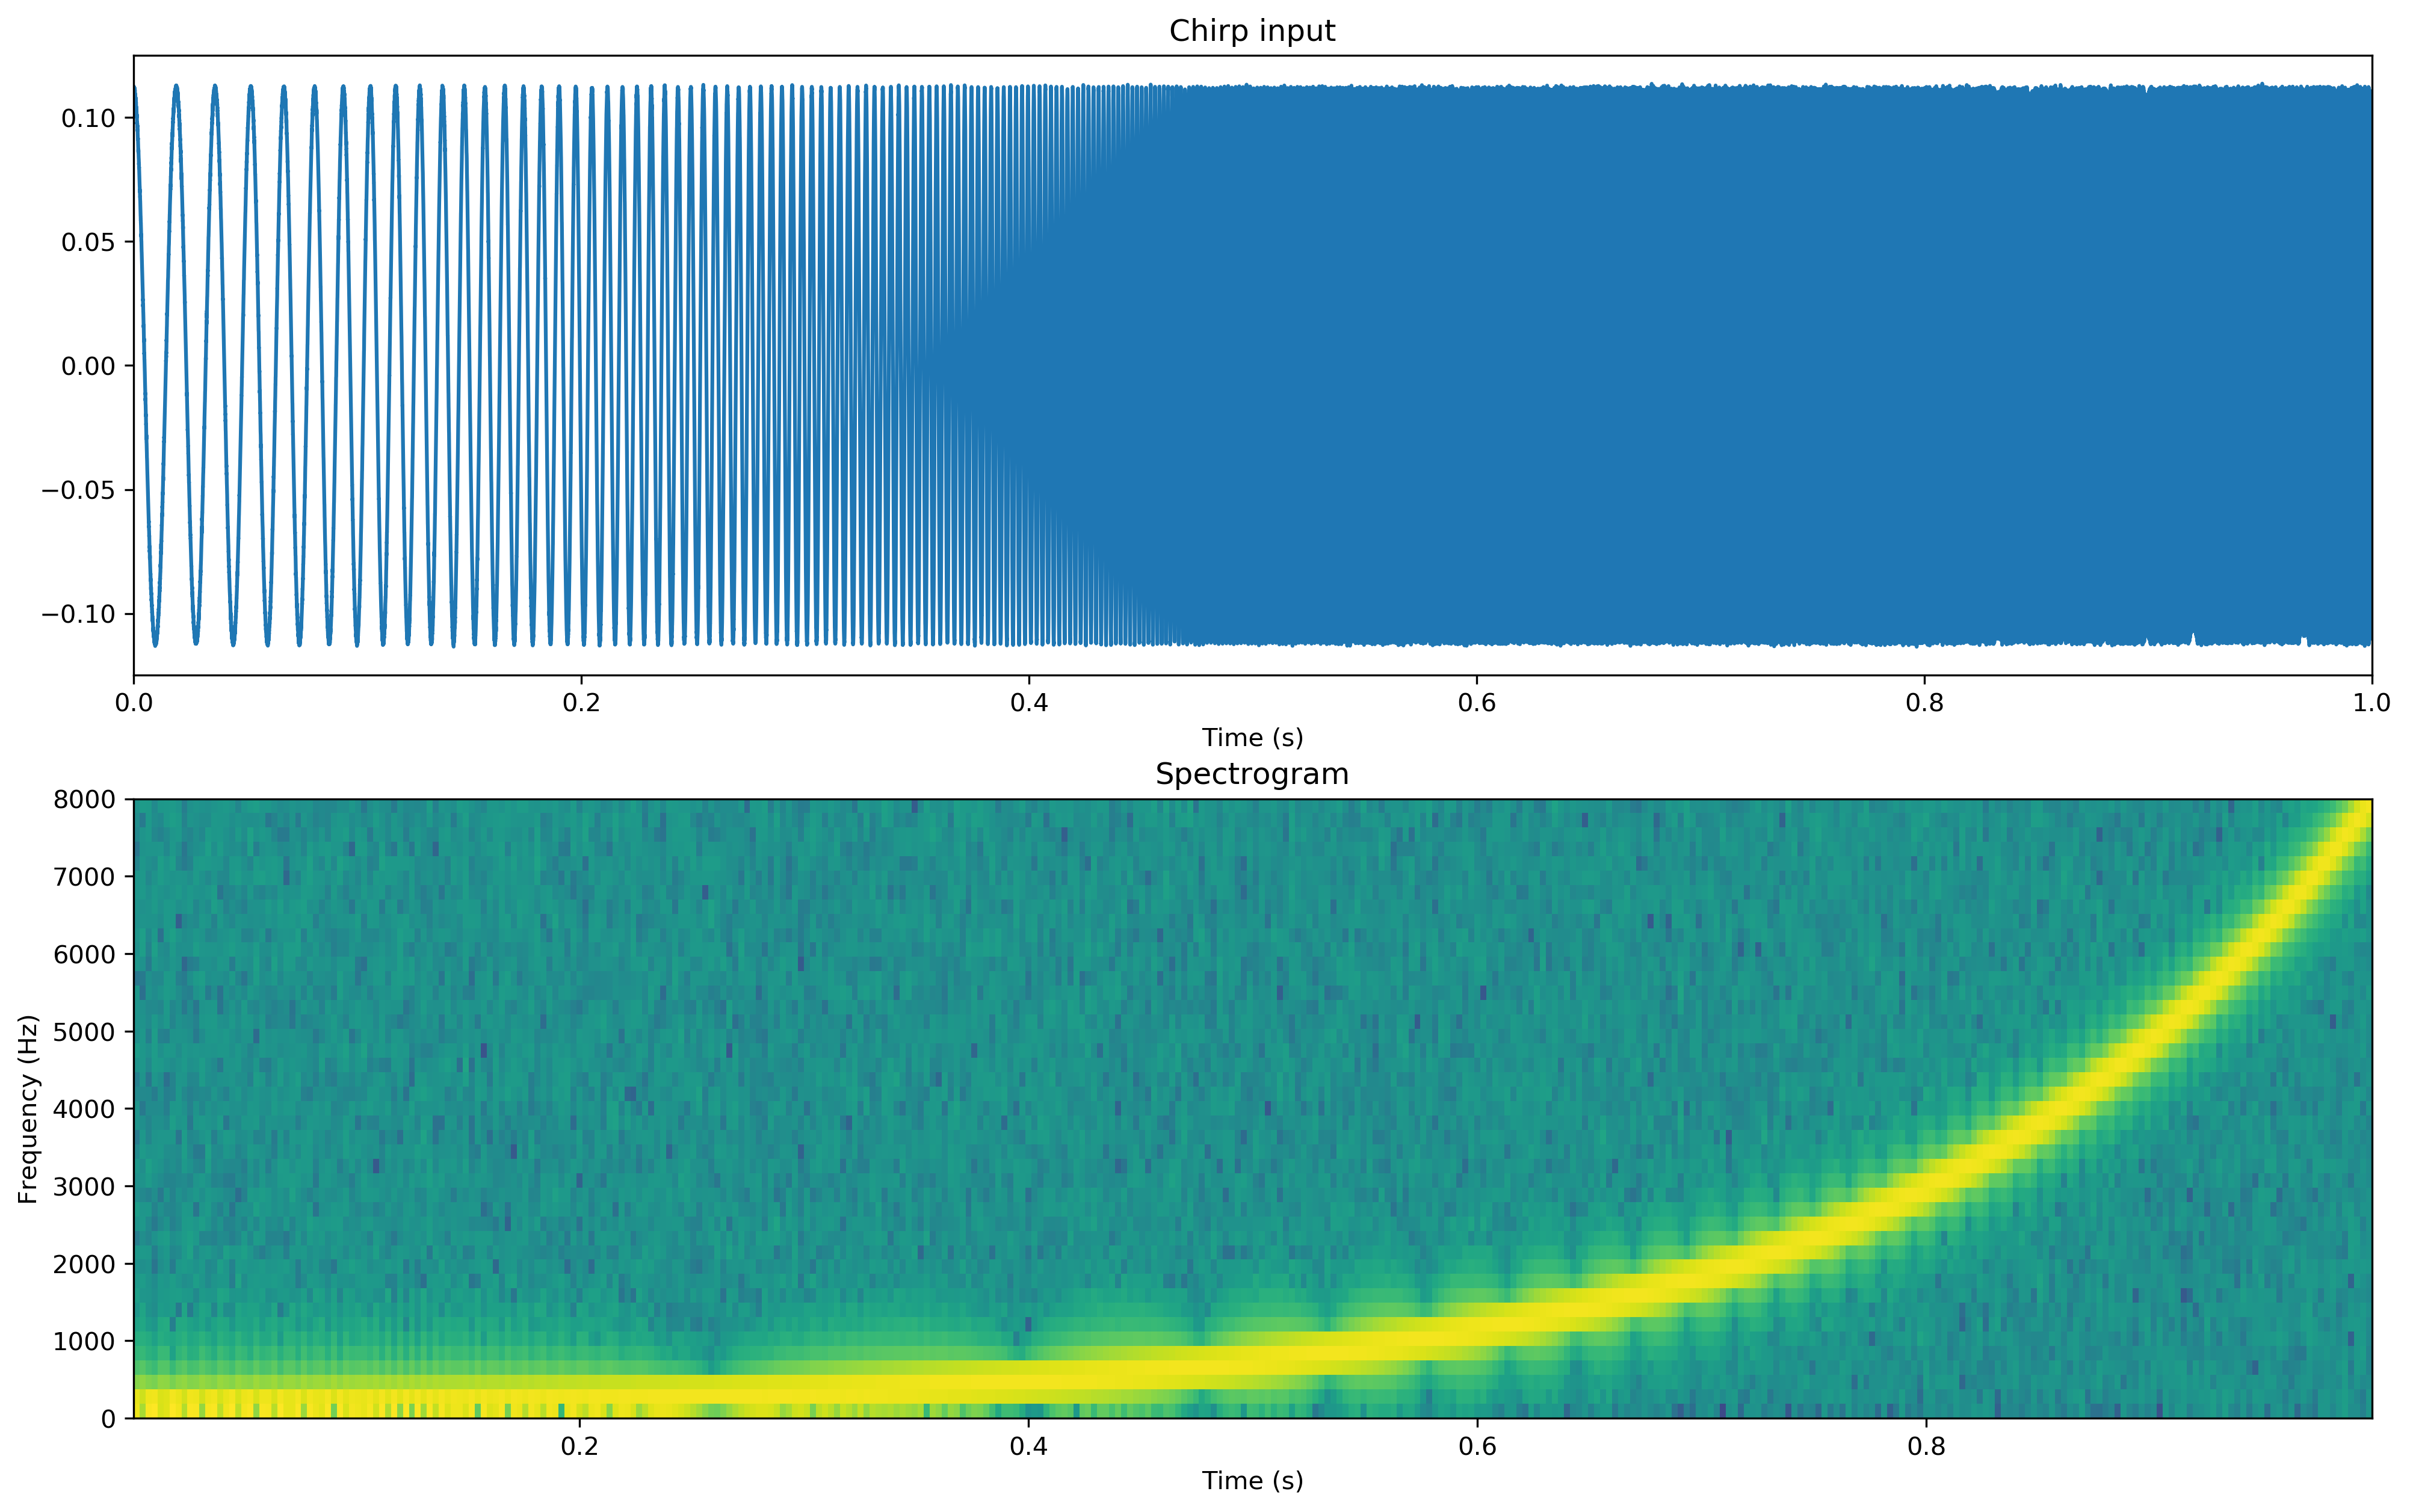

In [7]:
# - Plot the input signal
fig = plt.figure()
ax = fig.add_subplot(211)
inp_ts.plot()
# ax.set_xlim([0, 100e-3])

# - Plot a spectrogram
ax = fig.add_subplot(212)
ax.specgram(inp, Fs=fs)
ax.set_ylim([0, 8000])
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
ax.set_title('Spectrogram');

In the first panel we see the expected increase in frequency in the raw data. In the second panel we see that for increasing time slices the dominant frequencies components are increasing to 8kHz.

Now let's see how the AFE processes this data and plot the different stages.

The stages contain:

    - Low-noise amplification
    - Band-pass filters
    - Full-wave rectification
    - Spike conversion

In [8]:
filt_spikes, state, rec = afe(inp_ts, record=True)

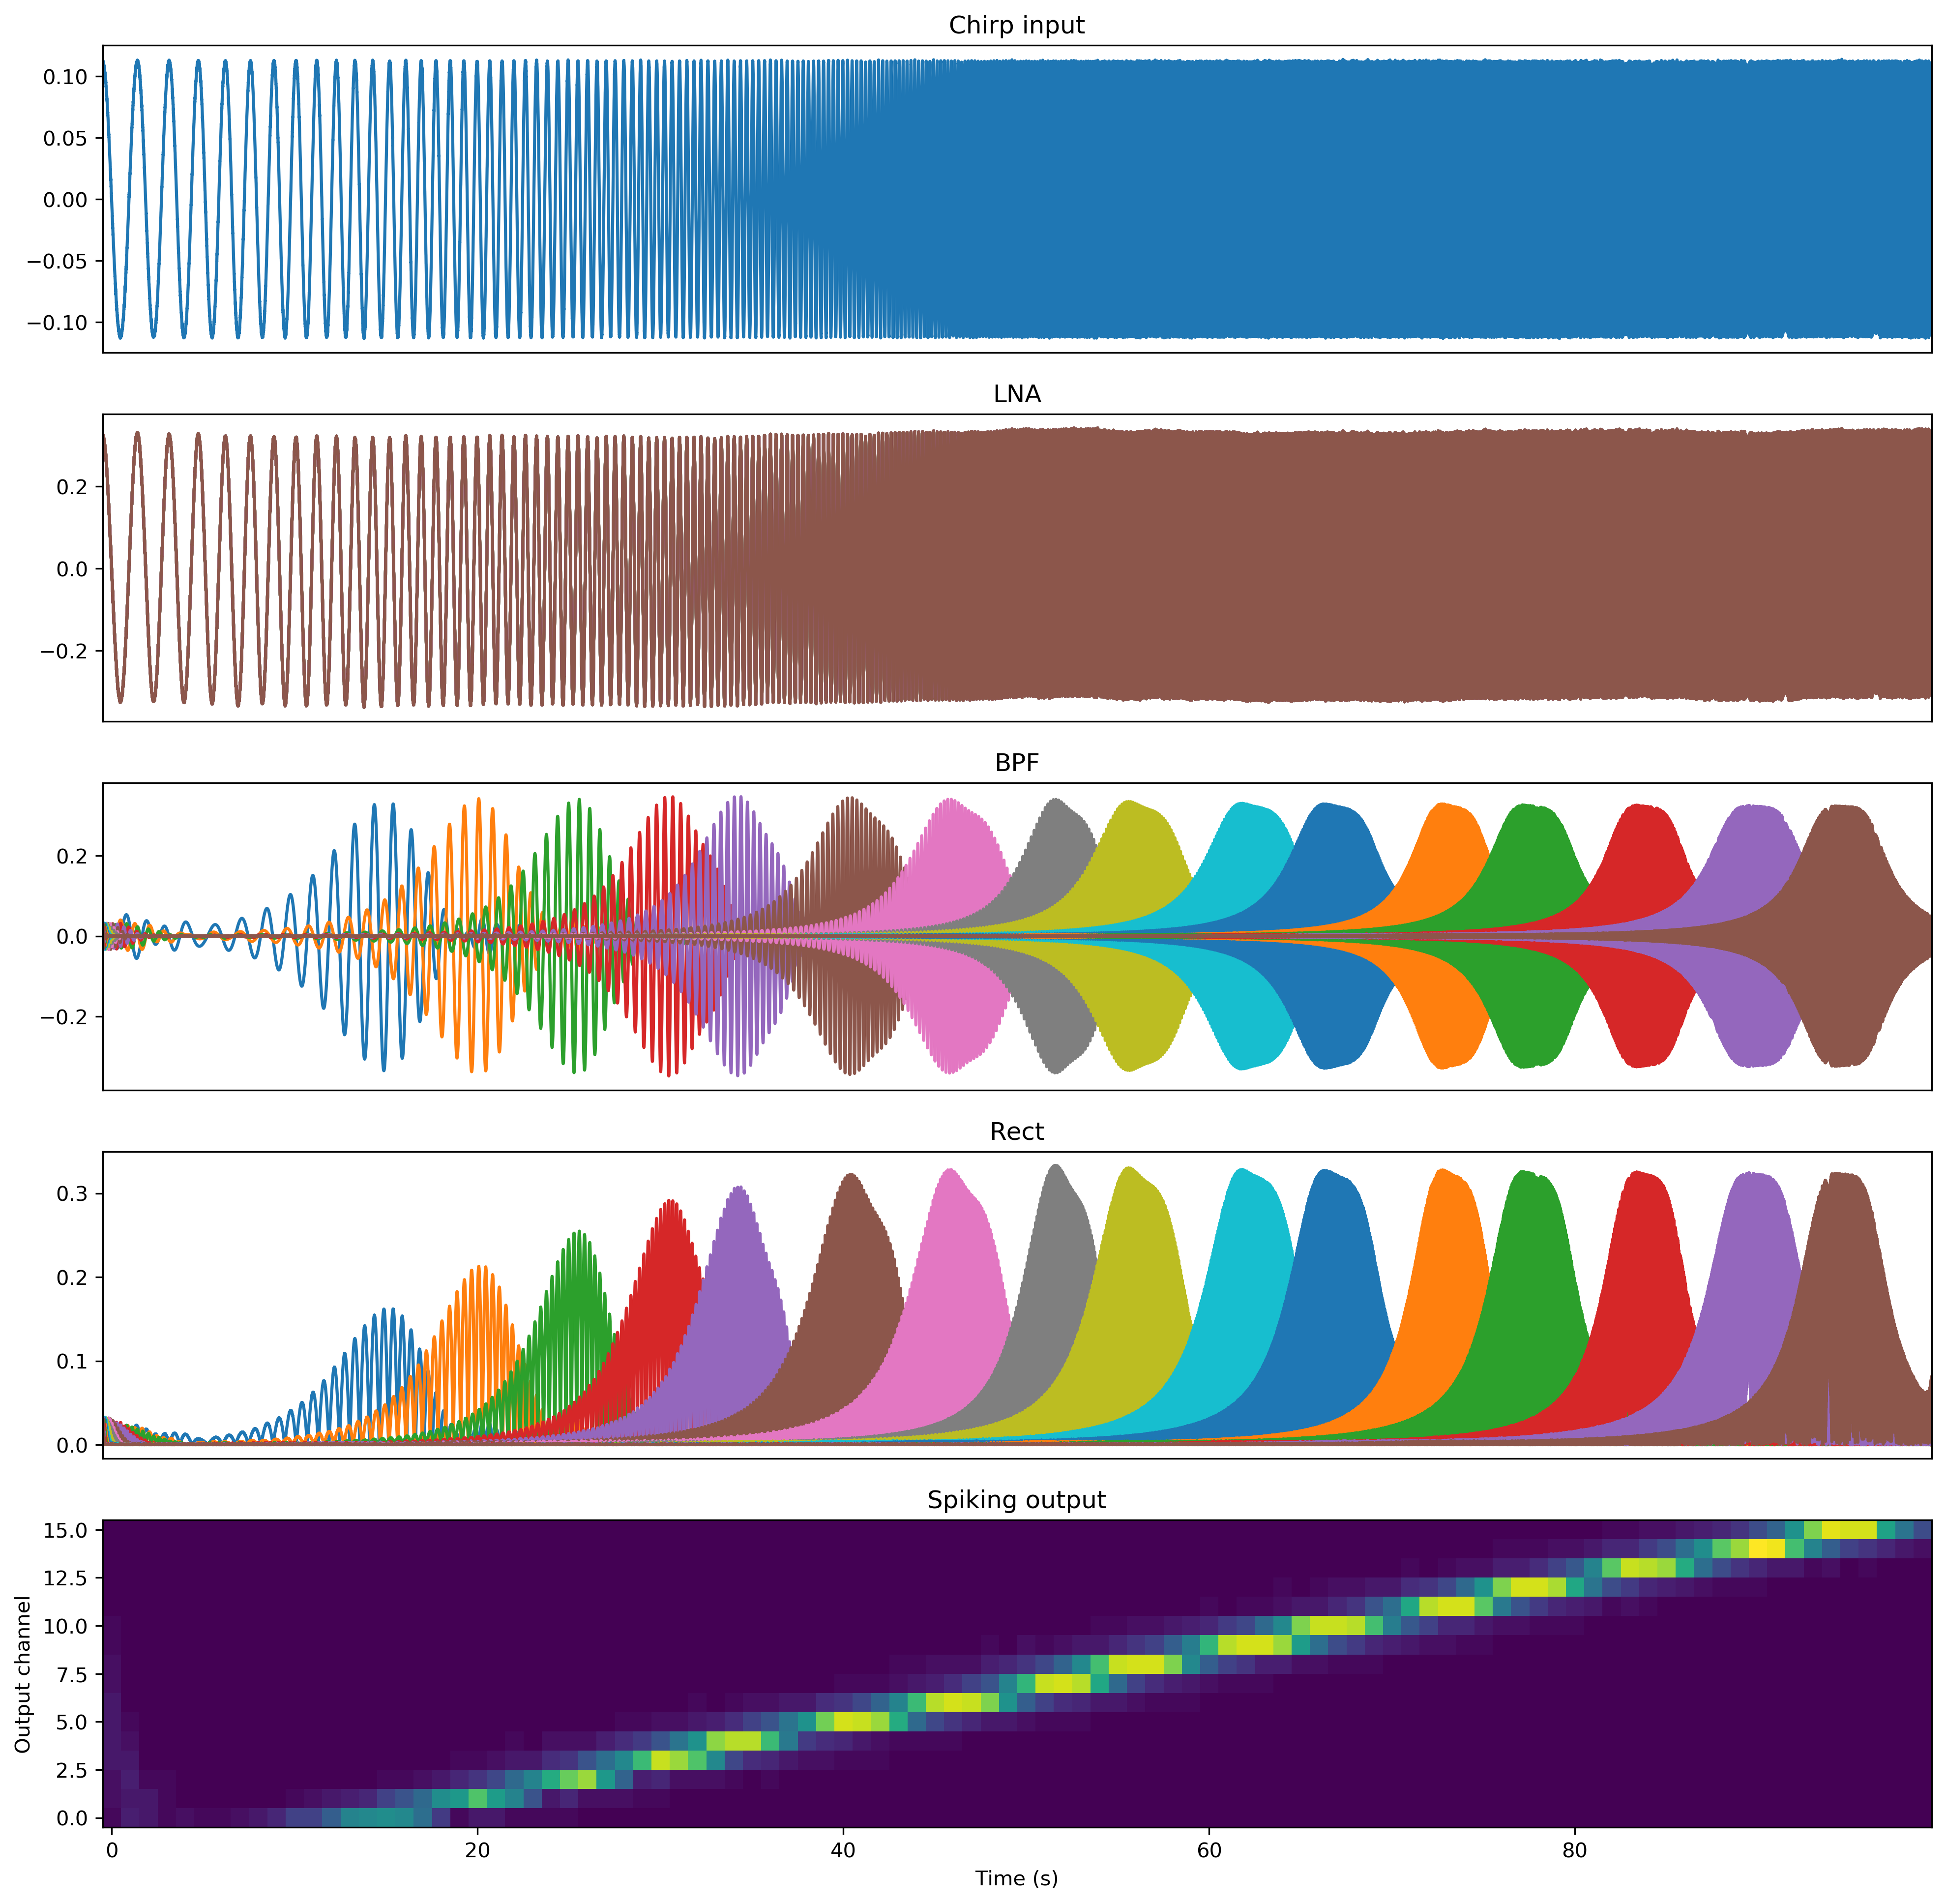

In [9]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(511)
inp_ts.plot()
ax.set_xticks([])
ax.set_xlabel('')

ax = fig.add_subplot(512)
rec['LNA_out'].plot()
ax.set_xticks([])
ax.set_xlabel('')

ax = fig.add_subplot(513)
rec['BPF'].plot()
ax.set_xticks([])
ax.set_xlabel('')

ax = fig.add_subplot(514)
rec['rect'].plot()
ax.set_xticks([])
ax.set_xlabel('')

ax = fig.add_subplot(515)
plt.imshow(filt_spikes.raster(dt = 10e-3, add_events = True).T, aspect='auto', origin='lower')
ax.set_xlabel('Time (s)');
ax.set_ylabel('Output channel');
ax.set_title("Spiking output");

In this previous plot we can see many things. Let's go through it piece by piece.

### Input

The first panel is simply the raw input signal.

### LNA

The low-noise amplifier provides normalisation and pre-amplification of the input signal, and simulates the distortion and nonlinearity present in the HW.

### BPF

The bandpass filter get active in the sequence of their center frequency. You can also see that their center frequency is logarithmically distributed. The center frequency is calculated using this equation: 

$fc_i = fc_{i-1} f_\mathrm{factor}^i + fc_\mathrm{mismatch}$ 

Also, the width of the filter is scaled with its center frequency. This can be manipulated using the `Q` factor.

### Rectification

The rectification corresponds to an `abs` operation but is also subject to noise. 

### Spike conversion

As can be seen in the last panel, the different channels emit spikes corresponding to the center frequencies of their band-pass filters.

The spike conversion is done by charging a capacitor with a current corresponding to the output of the full-wave recifier. If the capacitor reaches a threshold, a spike is produced. As the capacitor is rather small on the hardware, the spike rate can get very high. The solution was to use a digital counter. The digital counter allows only every `n`th spike to pass and drops the rest. `n` can be set using the `digital_counter` parameter

The capacitor is subject to leak, which can be set with the `leakage` parameter. It can be used to lower the impact of the noise floor. If the leak is high, small background noise does not lead to threshold crossing. Try it, if the leak is reduced, the noise generated by the AFE get's visible in the spiking output.